#Chicago Sex Offender Data

##Importing and Reading

###Reading Sex Offender Data From Website
Here we will read the data from the city of Chicago's website and store it in a dataframe

In [ ]:
import pandas as pd
!pip install sodapy
from sodapy import Socrata

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import Normalizer

client = Socrata("data.cityofchicago.org", None)

results = client.get("vc9r-bqvy", limit=2000)
sex_offender_df = pd.DataFrame.from_records(results)

     |████████████████████████████████| 829kB 7.3MB/s 
  Created wheel for future: filename=future-0.17.1-cp36-none-any.whl size=488730 sha256=014518edb95abdcb48556e029d368651aa2ba214e0bb3f904bb76f768d1a66e4
  Stored in directory: /root/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


##Cleaning Data

###Removing Females From the Dataframe
Because there are so few female sex offenders in this list (only about 22 of over 1000 records), I have decided to focus solely on male sex offenders.

In [ ]:
sex_offender_df=sex_offender_df[sex_offender_df.gender != 'FEMALE']

###Removing Duplicate Values

In [ ]:
sex_offender_df.drop_duplicates(inplace=True)

###Dropping Unnecessary Columns
We do not need the names of the offenders, thus we can drop last and first (name), the block data is censored anyway and we will not be using it, so we can drop that too, the gender column is unnecessary since we only have males left after removing the females, and the birth_date column is superfluous since we already have the age of the offenders.

In [ ]:
sex_offender_df.drop(['last','first','block','gender','birth_date'] , axis=1 , inplace=True)

###Combining Black and White Hispanics
Because there are so few black hispanics (5), we will be grouping white and black hispanics into one encompassing term of "Hispanics".

In [ ]:
hispanic_bucket = {'WHITE HISPANIC':'HISPANIC',
            'BLACK HISPANIC':'HISPANIC'}

sex_offender_df['race'] = sex_offender_df['race'].replace(hispanic_bucket)

###Formatting Hieght, Weight, and Age as Numbers
The height, weight, and age columns are strings, so we'll have to convert them so python knows that they are numbers.

In [ ]:
sex_offender_df['height']=sex_offender_df['height'].astype(float)
sex_offender_df['weight']=sex_offender_df['weight'].astype(float)
sex_offender_df['age']=sex_offender_df['age'].astype(float)

###Correcting the Format of the Height Column
The height column is given in a weird way. It is given in a 3 digit number, the first representing the feet, and the last two representing the inches. Thus 5 foot 11 inches becomes 511. This becomes difficult to read and can mess up averages. Instead we will convert these heights to height in inches only, so 5 foot 11 inches becomes 71. There are also some clearly inccorect values such as 60, or 245. It is not clear what these are meant to represent (is 60 meant to be 600 or 60 inches), so we will give these values the median height. We will look for numbers whose last 2 digits are greater than 12 or if the number as a whole is too small (less than 2 feet tall).

In [ ]:
sex_offender_df.loc[sex_offender_df.height < 200, 'height'] = sex_offender_df.loc[:,"height"].median()
sex_offender_df.loc[sex_offender_df.height%100 >=12, 'height'] = sex_offender_df.loc[:,"height"].median()
sex_offender_df["height"]=((sex_offender_df["height"]//100)*12)+sex_offender_df["height"]%100

##Charts

###Height and Weight of Sex Offenders
One might that expect that intimidation is a helpful attribute for sex offenders. Thus, I would expect that the the height and weight of sex offenders to be higher than that of the average population. However, I would expect this to be more important when the victim is an adult, as height and weight are more important for intimidation in this case. When the victim is a minor, height and weight is less important since the fact that the offender is an adult can be intimidating enough. Therefore, I would expect the height and weight of sex offenders of adult victims to be higher than sex offenders of minor victims. Let's see what we get. (Note: The outliers from the weight boxplot have been removed to better visualize the range of the boxplots)

[Text(0, 0.5, 'Height'),
 Text(0.5, 0, 'Is Victim a Minor'),
 Text(0.5, 1.0, 'Height of Offender Based on Age of Victim')]

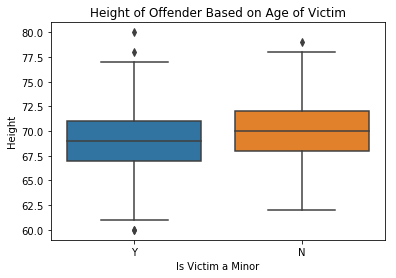

In [ ]:
ax=sns.boxplot(x="victim_minor", y="height", data=sex_offender_df)
ax.set(xlabel='Is Victim a Minor', ylabel='Height',title='Height of Offender Based on Age of Victim')

**Analysis:**
It would appear that our hypothesis is correct. There is a slight increase in height (around 1 inch) when the victim is an adult vs. a minor. The 25%, 50% and 75% height for minor victims is 67, 69, 71 inches respectively vs. 68, 70, 72 inches for adults. Note that the height of offenders with minor victims is almost spot on for the general distribution of U.S. males (67.01, 69.17, 71.02), so there does seem to be a slight increase for adult victims over the general population.

[Text(0, 0.5, 'Weight'),
 Text(0.5, 0, 'Is Victim a Minor'),
 Text(0.5, 1.0, 'Weight of Offender Based on Age of Victim')]

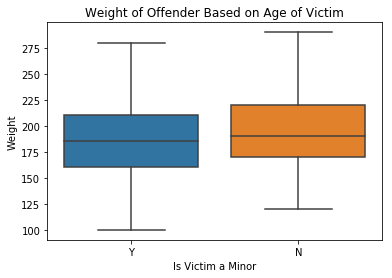

In [ ]:
ax=sns.boxplot(x="victim_minor", y="weight", data=sex_offender_df,showfliers=False)
ax.set(xlabel='Is Victim a Minor', ylabel='Weight',title='Weight of Offender Based on Age of Victim')

**Analysis:**
It would appear that our hypothesis is correct. There is a slight increase in weight (around 5-10 pounds) when the victim is an adult vs. a minor. The 25%, 50% and 75% weight for minor victims is 160, 185, 210 pounds respectively vs. 170, 190, 220 pounds for adults. Note that the general distribution of U.S. males is 164.9, 189.4, 222.4.

###Breakdown of Race
Let us see the breakdown of sex offenders by race. Let's make a bar chart to see the count of each group and display the percentages of each group. Since there is one person with unknown race, we will exclude him from this chart.

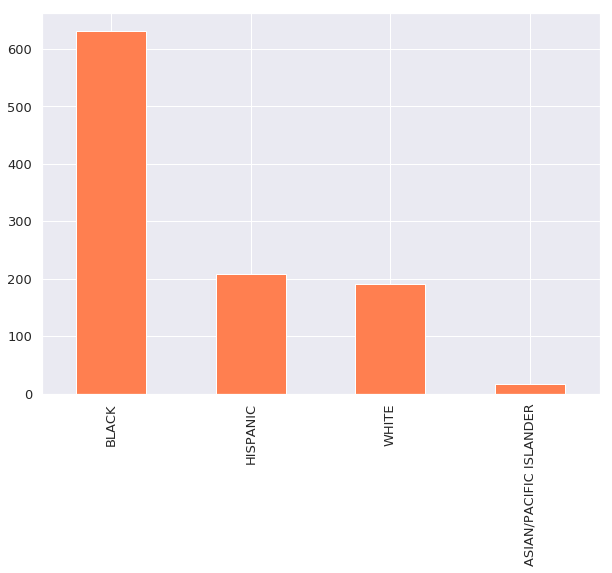

In [ ]:
fixed_race=sex_offender_df[sex_offender_df.race != 'UNKNOWN']

ax = fixed_race['race'].value_counts().plot(kind='bar', figsize=(10,7),color="coral", fontsize=13);
ax.set_alpha(0.8)
ax.set_title("Race of Sex Offenders", fontsize=18)
ax.set_xlabel("Frequency", fontsize=18)
ax.set_ylabel("Race", fontsize=18)
ax.set_xticks([0,100, 200, 300, 400, 500, 600, 700])

totals = []

for i in ax.patches:
    totals.append(i.get_width())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=15,color='dimgrey')
ax.invert_yaxis()

**Analysis:**
The race of sex offenders is overwhelmingly black, followed by whites and hispanics, and then a few asians/pacific islanders. However it is important to take into account the demographics of Chicago to better understand this. Based on 2016 data, white (non hispanic), blacks, hispanics, and asian/pacific islanders represent 32.6%, 29.3%, 29.7% and 5.4% respectively. Thus it would appear, blacks are greatly overrepresented among sex offenders.

###Age Distribution of Sex Offenders
Let's now see what is the distribution of the ages of registered sex offenders are.

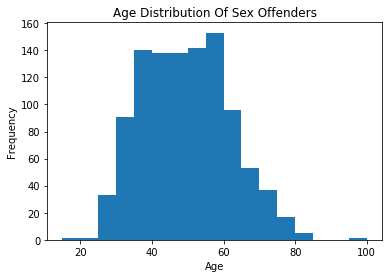

In [ ]:
plt.hist(sex_offender_df.age,bins=[15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100])
plt.title('Age Distribution Of Sex Offenders')
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

**Analysis:**
It would seeem that the ages of sex offenders are not uniform. As would be expected, there are not so many sex offenders among the older population. This is probably because physical strength is sometimes needed and because the intimidation factor is diminished if the offender is too old. The most common ages seem to fall between 35 and 60

###Percentages Overall and Within Each Race Group of Minor Victims
Let us now compare the number of sex offender victims that are minors vs adults, overall and by race.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Is Victim a Minor'),
 Text(0.5, 1.0, "Number of Offenders Based on Victim's Age")]

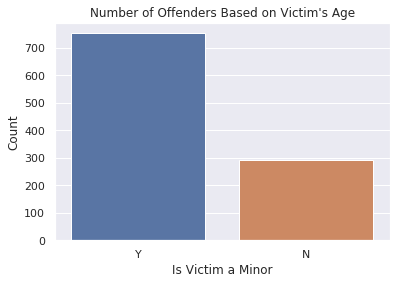

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="victim_minor",data=fixed_race)
ax.set(xlabel='Is Victim a Minor', ylabel='Count',title='Number of Offenders Based on Victim\'s Age')

**Analysis:**
The majority of victims are minors. Around 30% of victims are adults.

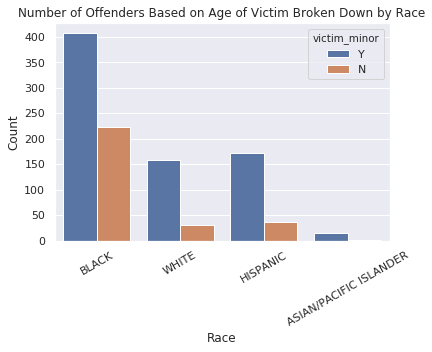

In [ ]:
sns.set(style="darkgrid")
ax = sns.countplot(x="race", hue="victim_minor",data=fixed_race)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(xlabel='Race', ylabel='Count',title='Number of Offenders Based on Age of Victim Broken Down by Race')
sns.set(rc={'figure.figsize':(19,16)})

**Analysis:**
While all races follow the same pattern of having more minor victims, blacks have a significantly higher percentage of adult victims (around 1/3) than other races. Whites and hispanics seem about similar while there might not be enough data to make any conclusions about asians/pacific islanders.

##Conclusion

Based on these results we have found the following findings:  
1) Male sex offenders with adult victims are both slightly heavier and taller than those with younger victims.  
2) Registered male sex offenders in Chicago are disproportionately black.  
3) Male sex offenders vary in age but generally fall within the 35-60 age group.  
4) Most male sex offenders have minor victims.  
5) Black male sex offenders are more likely than other groups to have adult victims.